## Analysis of model coefficients

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
results_dir = os.path.join(cfg.results_dirs['mutation'], 'gene')

In [3]:
coefs_df = pd.DataFrame()
for identifier, coefs_list in au.generate_nonzero_coefficients(results_dir):
    coefs_list_df = pd.DataFrame({
        'gene': identifier.split('_')[0],
        'training_data': identifier.split('_')[1],
        'fold': list(range(len(coefs_list))),
        'nz_coefs': [len(l) for l in coefs_list]
    })
    coefs_df = pd.concat((coefs_df, coefs_list_df))
    
coefs_df.sort_values(by='nz_coefs', ascending=False).head(10)

,gene,training_data,fold,nz_coefs
2,GNAQ,expression,2,1174
2,GNAQ,expression,2,730
2,CBL,expression,2,592
3,MLH1,expression,3,523
1,TSHR,methylation,1,521
1,GATA3,expression,1,486
3,CBL,expression,3,478
3,JAK1,expression,3,452
3,DNMT3A,expression,3,447
2,GATA3,expression,2,436


Text(0.5, 1.0, 'Nonzero coefficient distribution, expression vs. methylation data')

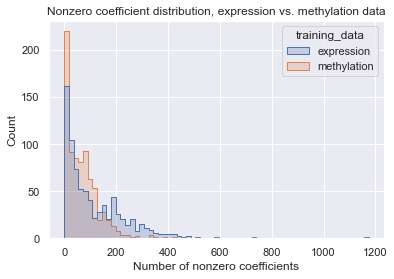

In [4]:
sns.set()
sns.histplot(data=coefs_df, x='nz_coefs', hue='training_data', element='step')
plt.xlabel('Number of nonzero coefficients')
plt.title('Nonzero coefficient distribution, expression vs. methylation data')

In [5]:
# get gene -> significant predictor info
SIG_ALPHA = 0.001 # TODO: store in config?

results_df = au.load_stratified_prediction_results(results_dir, 'gene')
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='identifier',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=SIG_ALPHA,
                                           verbose=True)
expression_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
expression_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
15,BRAF,0.617245,1.121428e-19,1.087785e-17,True
25,CTNNB1,0.593111,3.305822e-18,1.301609e-16,True
28,EGFR,0.584966,4.025594e-18,1.301609e-16,True
72,PIK3CA,0.345058,5.853374e-18,1.419443e-16,True
5,ARID1A,0.424040,1.412938e-16,2.741100e-15,True
93,TP53,0.404853,3.483038e-16,5.630911e-15,True
3,APC,0.582659,8.595405e-16,1.191078e-14,True
54,KRAS,0.474406,1.442342e-15,1.748840e-14,True
22,CIC,0.545687,7.647812e-15,8.242642e-14,True
30,ERBB2,0.571202,1.846692e-14,1.791291e-13,True


In [6]:
coefs_sig_df = coefs_df.merge(expression_results_df, how='inner', on='gene')
print(coefs_df.shape)
print(coefs_sig_df.shape)
coefs_sig_df.head()

(1584, 4)
(1536, 8)


,gene,training_data,fold,nz_coefs,delta_mean,p_value,corr_pval,reject_null
0,MAP3K1,expression,0,377,0.250817,7.362098e-11,3.400588e-10,True
1,MAP3K1,expression,1,416,0.250817,7.362098e-11,3.400588e-10,True
2,MAP3K1,expression,2,165,0.250817,7.362098e-11,3.400588e-10,True
3,MAP3K1,expression,3,300,0.250817,7.362098e-11,3.400588e-10,True
4,MAP3K1,methylation,0,37,0.250817,7.362098e-11,3.400588e-10,True


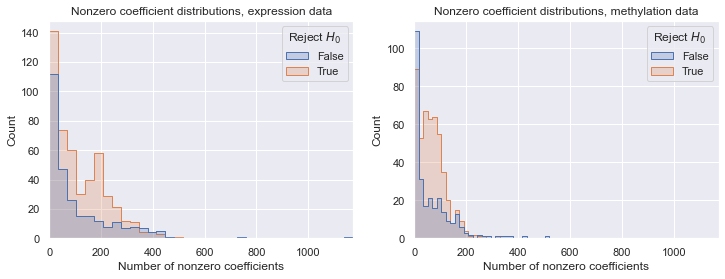

In [7]:
sns.set({'figure.figsize': (12, 4)})
fig, axarr = plt.subplots(1, 2)

x_max = max(coefs_sig_df.nz_coefs)

sns.histplot(data=coefs_sig_df[coefs_sig_df.training_data == 'expression'], 
             x='nz_coefs', hue='reject_null', element='step', ax=axarr[0])
axarr[0].set_xlabel('Number of nonzero coefficients')
axarr[0].set_xlim(0, x_max)
axarr[0].set_title('Nonzero coefficient distributions, expression data')
# https://github.com/mwaskom/seaborn/issues/2280#issuecomment-692350136
h = axarr[0].legend_.legendHandles
l = [t.get_text() for t in axarr[0].legend_.get_texts()]
axarr[0].legend(h, l, title=r'Reject $H_0$')

sns.histplot(data=coefs_sig_df[coefs_sig_df.training_data == 'methylation'], 
             x='nz_coefs', hue='reject_null', element='step', ax=axarr[1])
axarr[1].set_xlabel('Number of nonzero coefficients')
axarr[1].set_xlim(0, x_max)
axarr[1].set_title('Nonzero coefficient distributions, methylation data')
h = axarr[1].legend_.legendHandles
l = [t.get_text() for t in axarr[1].legend_.get_texts()]
axarr[1].legend(h, l, title=r'Reject $H_0$')

Text(0.5, 1.0, 'Nonzero coefs vs. p-value, significant genes ($r$=0.2832, $p$=0.0016)')

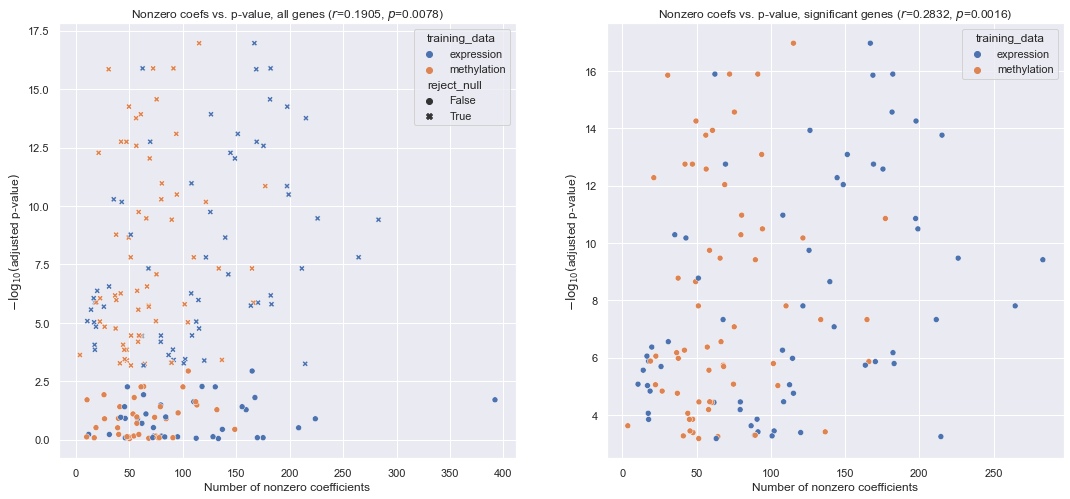

In [8]:
# is there a correlation between number of nonzero model coefficients and predictive ability?
# TL;DR: not really (maybe slight positive correlation)
import scipy.stats as st

sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

coefs_sig_df['nlog10_p'] = -np.log10(coefs_sig_df.corr_pval)
# take mean # of nonzero coefficients over CV folds
data_df = coefs_sig_df.groupby(['gene', 'training_data']).mean()

sns.scatterplot(data=data_df, x='nz_coefs', y='nlog10_p', hue='training_data', style='reject_null', ax=axarr[0])
axarr[0].set_xlabel('Number of nonzero coefficients')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted p-value$)$')
axarr[0].set_title(r'Nonzero coefs vs. p-value, all genes ($r$={:.4f}, $p$={:.4f})'.format(*st.pearsonr(data_df.nz_coefs, data_df.nlog10_p)))

filtered_df = data_df[data_df.reject_null]
sns.scatterplot(data=filtered_df, x='nz_coefs', y='nlog10_p', hue='training_data', ax=axarr[1])
axarr[1].set_xlabel('Number of nonzero coefficients')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted p-value$)$')
axarr[1].set_title(r'Nonzero coefs vs. p-value, significant genes ($r$={:.4f}, $p$={:.4f})'.format(*st.pearsonr(filtered_df.nz_coefs, filtered_df.nlog10_p)))